In [1]:
import sys
import time
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

from tensorflow import keras
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

from keras_flops import get_flops

In [3]:
# input image dimensions(pixel)
img_rows, img_cols = 32, 32
num_classes = 10

In [4]:
# x為圖片的陣列，y為答案陣列
#例如：x_train有60000筆28×28的data。
#例如：x_test有10000筆28×28的data。
(x_train, y_train),(x_test, y_test) = cifar10.load_data() 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#特徵值進行標準化，方法是除以255（因為圖像的像素點介於0~255之間），可讓所有的特徵值介於0與1之間
x_train /= 255 
x_test /= 255

# CNN 輸出層的每筆 Data 都是一維陣列
# 需將 Train Label(答案) 資料轉換為 One-Hot Encoding, 也就是
# 1 轉換為 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
# 5 轉換為 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# 9 轉換為 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

input_shape=(32,32,3)

In [5]:
# 自定義callback來計算模型的訓練時間
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
def RegularConv():
    #建立一個線性堆疊模型，之後我們只要將建立的神經網路層依次加入即可。
    model = Sequential()

    #建立卷積層並加入model
    model.add(Conv2D(512, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.35))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.35))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))


    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def BothConv():
    model = Sequential()

    model.add(Conv2D(512, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.35))
    model.add(SeparableConv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.35))
    model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.35))
    model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def SeparableConv():
    model = Sequential()

    model.add(SeparableConv2D(512, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.35))
    model.add(SeparableConv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.35))
    model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.35))
    model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [7]:
Model1 = RegularConv()
Model2 = BothConv()
Model3 = SeparableConv()

models = [Model1, Model2, Model3]
times = []

In [8]:
#訓練次數
epochs = 150
batch_size = 256
historys = []

# 設定模型的訓練方式
for model in models:
    
    time_callback = TimeHistory()
    times.append(time_callback)
    
    model.compile(loss=keras.losses.categorical_crossentropy,  # 設定 Loss 損失函數
                  optimizer=keras.optimizers.Adam(0.0001),      # 設定 Optimizer 最佳化方法 
                  metrics=['accuracy'])                        # 設定 Model 評估準確率方法 為 accuracy

    # 開始訓練
    # CNN 輸入層的每筆 Data 都是三維陣列, 這就是為何 x 輸入 標準化_x_train 或 原始_x_train 皆可
    # CNN 輸出層的每筆 Data 都是一維陣列, 這就是為何 y 輸入 經過前處理_y_train, 而非 原始train_label
    # (若準確率不高, 改善 1: 可再執行這個函數, 進行重覆訓練)
    # (若準確率不高, 改善 2: 重新建立 Model, 且增加 卷積層 filter 數, 重新進行訓練)
    # (若準確率不高, 改善 3: 重新建立 Model, 且增加 隱藏層 units 神經元數, 重新進行訓練)
    # (若準確率不高, 改善 4: 重新建立 Model, 且增加 隱藏層 layer, 重新進行訓練)
    # (若準確率不高, 改善 5: 重新建立 Model, 且更換訓練方式（神經網路）, 重新進行訓練)

    history = model.fit(x_train,                          # 設定 圖片 Features 特徵值
              y_train,                          # 設定 圖片 Label    答案
              batch_size=batch_size,            # 設定 訓練時每批次有多少筆 (值100以上, 值越大訓練速度越快, 但需記憶體要夠大)
              epochs=epochs,                    # 設定 訓練次數 (值越大訓練時間越久, 但訓練越精準)
              verbose=1,                        # 是否 顯示訓練過程 (0: 不顯示, 1: 詳細顯示, 2: 簡易顯示)
              validation_data=(x_test, y_test),
              callbacks=[time_callback])
    
    historys.append(history)

Epoch 1/150
196/196 [==============================] - 64s 281ms/step - loss: 2.3992 - accuracy: 0.1574 - val_loss: 2.8436 - val_accuracy: 0.1000
Epoch 2/150
196/196 [==============================] - 52s 263ms/step - loss: 2.0672 - accuracy: 0.2378 - val_loss: 3.1421 - val_accuracy: 0.1000
Epoch 3/150
196/196 [==============================] - 53s 268ms/step - loss: 1.8901 - accuracy: 0.2944 - val_loss: 2.5614 - val_accuracy: 0.1352
Epoch 4/150
196/196 [==============================] - 55s 280ms/step - loss: 1.7594 - accuracy: 0.3363 - val_loss: 2.7490 - val_accuracy: 0.1846
Epoch 5/150
196/196 [==============================] - 55s 280ms/step - loss: 1.6475 - accuracy: 0.3829 - val_loss: 2.3630 - val_accuracy: 0.2560
Epoch 6/150
196/196 [==============================] - 52s 264ms/step - loss: 1.5596 - accuracy: 0.4189 - val_loss: 1.9405 - val_accuracy: 0.3334
Epoch 7/150
196/196 [==============================] - 53s 272ms/step - loss: 1.4866 - accuracy: 0.4492 - val_loss: 2.1626 -

196/196 [==============================] - 54s 274ms/step - loss: 0.3096 - accuracy: 0.8960 - val_loss: 0.5390 - val_accuracy: 0.8414
Epoch 56/150
196/196 [==============================] - 52s 266ms/step - loss: 0.3034 - accuracy: 0.8998 - val_loss: 0.6154 - val_accuracy: 0.8245
Epoch 57/150
196/196 [==============================] - 54s 274ms/step - loss: 0.2934 - accuracy: 0.9021 - val_loss: 0.5538 - val_accuracy: 0.8394
Epoch 58/150
196/196 [==============================] - 53s 271ms/step - loss: 0.2917 - accuracy: 0.9027 - val_loss: 0.7466 - val_accuracy: 0.8023
Epoch 59/150
196/196 [==============================] - 57s 293ms/step - loss: 0.2839 - accuracy: 0.9054 - val_loss: 0.5904 - val_accuracy: 0.8312
Epoch 60/150
196/196 [==============================] - 55s 278ms/step - loss: 0.2759 - accuracy: 0.9073 - val_loss: 0.6046 - val_accuracy: 0.8290
Epoch 61/150
196/196 [==============================] - 53s 273ms/step - loss: 0.2691 - accuracy: 0.9100 - val_loss: 0.5433 - val_a

Epoch 111/150
196/196 [==============================] - 55s 279ms/step - loss: 0.1051 - accuracy: 0.9655 - val_loss: 0.6116 - val_accuracy: 0.8624
Epoch 112/150
196/196 [==============================] - 53s 273ms/step - loss: 0.1030 - accuracy: 0.9657 - val_loss: 0.7220 - val_accuracy: 0.8493
Epoch 113/150
196/196 [==============================] - 57s 292ms/step - loss: 0.1053 - accuracy: 0.9652 - val_loss: 0.5344 - val_accuracy: 0.8792
Epoch 114/150
196/196 [==============================] - 55s 278ms/step - loss: 0.1027 - accuracy: 0.9658 - val_loss: 0.5742 - val_accuracy: 0.8691
Epoch 115/150
196/196 [==============================] - 55s 282ms/step - loss: 0.1003 - accuracy: 0.9668 - val_loss: 0.5855 - val_accuracy: 0.8688
Epoch 116/150
196/196 [==============================] - 54s 277ms/step - loss: 0.0973 - accuracy: 0.9686 - val_loss: 0.5953 - val_accuracy: 0.8674
Epoch 117/150
196/196 [==============================] - 55s 279ms/step - loss: 0.0949 - accuracy: 0.9688 - val_

Epoch 15/150
196/196 [==============================] - 27s 137ms/step - loss: 0.9196 - accuracy: 0.6772 - val_loss: 1.0512 - val_accuracy: 0.6379
Epoch 16/150
196/196 [==============================] - 27s 137ms/step - loss: 0.8930 - accuracy: 0.6881 - val_loss: 1.1990 - val_accuracy: 0.6222
Epoch 17/150
196/196 [==============================] - 27s 137ms/step - loss: 0.8655 - accuracy: 0.6995 - val_loss: 0.9415 - val_accuracy: 0.6766
Epoch 18/150
196/196 [==============================] - 27s 137ms/step - loss: 0.8429 - accuracy: 0.7074 - val_loss: 1.0469 - val_accuracy: 0.6519
Epoch 19/150
196/196 [==============================] - 27s 137ms/step - loss: 0.8122 - accuracy: 0.7187 - val_loss: 0.8665 - val_accuracy: 0.7034
Epoch 20/150
196/196 [==============================] - 27s 138ms/step - loss: 0.7923 - accuracy: 0.7264 - val_loss: 1.1738 - val_accuracy: 0.6390
Epoch 21/150
196/196 [==============================] - 27s 137ms/step - loss: 0.7830 - accuracy: 0.7294 - val_loss: 0

Epoch 71/150
196/196 [==============================] - 30s 151ms/step - loss: 0.3513 - accuracy: 0.8819 - val_loss: 0.6531 - val_accuracy: 0.8106
Epoch 72/150
196/196 [==============================] - 30s 154ms/step - loss: 0.3431 - accuracy: 0.8822 - val_loss: 0.6998 - val_accuracy: 0.8085
Epoch 73/150
196/196 [==============================] - 30s 151ms/step - loss: 0.3413 - accuracy: 0.8836 - val_loss: 0.6334 - val_accuracy: 0.8145
Epoch 74/150
196/196 [==============================] - 28s 145ms/step - loss: 0.3371 - accuracy: 0.8853 - val_loss: 0.6542 - val_accuracy: 0.8139
Epoch 75/150
196/196 [==============================] - 28s 141ms/step - loss: 0.3283 - accuracy: 0.8876 - val_loss: 0.7154 - val_accuracy: 0.7996
Epoch 76/150
196/196 [==============================] - 28s 143ms/step - loss: 0.3305 - accuracy: 0.8881 - val_loss: 0.7821 - val_accuracy: 0.7877
Epoch 77/150
196/196 [==============================] - 29s 150ms/step - loss: 0.3247 - accuracy: 0.8890 - val_loss: 0

Epoch 30/150
196/196 [==============================] - 28s 144ms/step - loss: 0.9034 - accuracy: 0.6852 - val_loss: 1.2157 - val_accuracy: 0.5919
Epoch 31/150
196/196 [==============================] - 27s 140ms/step - loss: 0.8853 - accuracy: 0.6904 - val_loss: 1.0420 - val_accuracy: 0.6464
Epoch 32/150
196/196 [==============================] - 29s 146ms/step - loss: 0.8753 - accuracy: 0.6940 - val_loss: 0.9590 - val_accuracy: 0.6736
Epoch 33/150
196/196 [==============================] - 29s 146ms/step - loss: 0.8637 - accuracy: 0.6973 - val_loss: 1.0806 - val_accuracy: 0.6395
Epoch 34/150
196/196 [==============================] - 28s 144ms/step - loss: 0.8540 - accuracy: 0.7023 - val_loss: 0.9726 - val_accuracy: 0.6728
Epoch 35/150
196/196 [==============================] - 29s 146ms/step - loss: 0.8435 - accuracy: 0.7034 - val_loss: 1.0766 - val_accuracy: 0.6452
Epoch 36/150
196/196 [==============================] - 28s 141ms/step - loss: 0.8353 - accuracy: 0.7073 - val_loss: 0

196/196 [==============================] - 30s 153ms/step - loss: 0.4090 - accuracy: 0.8576 - val_loss: 0.6404 - val_accuracy: 0.8024
Epoch 141/150
196/196 [==============================] - 29s 150ms/step - loss: 0.4065 - accuracy: 0.8581 - val_loss: 0.6109 - val_accuracy: 0.8116
Epoch 142/150
196/196 [==============================] - 29s 150ms/step - loss: 0.4001 - accuracy: 0.8619 - val_loss: 0.5989 - val_accuracy: 0.8132
Epoch 143/150
196/196 [==============================] - 28s 142ms/step - loss: 0.4014 - accuracy: 0.8608 - val_loss: 0.6148 - val_accuracy: 0.8120
Epoch 144/150
196/196 [==============================] - 27s 139ms/step - loss: 0.3996 - accuracy: 0.8606 - val_loss: 0.6430 - val_accuracy: 0.8076
Epoch 145/150
196/196 [==============================] - 27s 139ms/step - loss: 0.3944 - accuracy: 0.8625 - val_loss: 0.6415 - val_accuracy: 0.8063
Epoch 146/150
196/196 [==============================] - 28s 144ms/step - loss: 0.3971 - accuracy: 0.8628 - val_loss: 0.6088 -

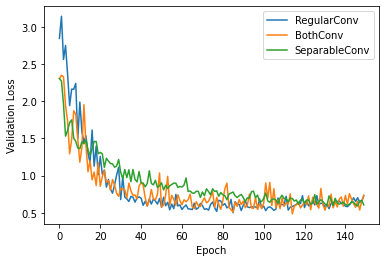

In [9]:
# Loss
modellist = ["RegularConv", "BothConv", "SeparableConv"]
color = ['#1f77b4', '#ff7f0e', '#2ca02c']

for index in range(len(historys)):
    plt.plot(historys[index].history['val_loss'], label=modellist[index], color=color[index])
    
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(loc = 0)
plt.show()

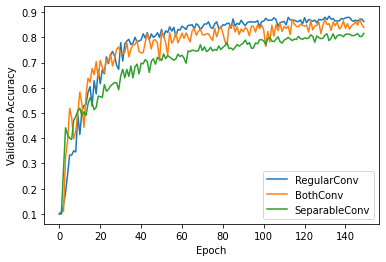

In [10]:
# Accuracy
modellist = ["RegularConv", "BothConv", "SeparableConv"]
color = ['#1f77b4', '#ff7f0e', '#2ca02c']

for index in range(len(historys)):
    plt.plot(historys[index].history['val_accuracy'], label=modellist[index], color=color[index])
    
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 0)
plt.show()

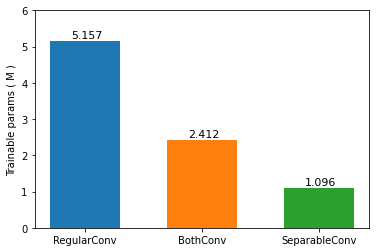

In [11]:
# params 
modellist = ["RegularConv", "BothConv", "SeparableConv"]
color = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(6, 4))
for index in range(len(modellist)):
    params = models[index].count_params()/1000000
    plt.bar(modellist[index], params, color=color[index], width=0.6)
    plt.text(index-0.12, params+0.08, '%.3f' % params,fontsize=11)
    
plt.ylim(0, 6)
plt.ylabel('Trainable params ( M )')
plt.show()

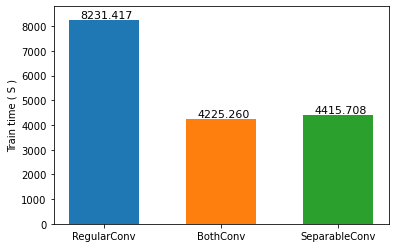

In [14]:
# Time 
modellist = ["RegularConv", "BothConv", "SeparableConv"]
color = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(6, 4))
for index in range(len(modellist)):
    plt.bar(modellist[index], sum(times[index].times), color=color[index], width=0.6)
    plt.text(index-0.2, sum(times[index].times)+80, '%.3f' % sum(times[index].times),fontsize=11)
    
plt.ylim(0, 8800)
plt.ylabel('Train time ( S )')
plt.show()


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


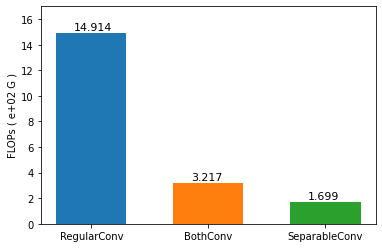

In [13]:
# FLOPs 
modellist = ["RegularConv", "BothConv", "SeparableConv"]
color = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(6, 4))
for index in range(len(modellist)):
    flops = get_flops(models[index], batch_size=batch_size)/10**11
    plt.bar(modellist[index], flops, color=color[index], width=0.6)
    plt.text(index-0.15, flops+0.2, '%.3f' % flops,fontsize=11)
    
plt.ylim(0, 17)    
plt.ylabel('FLOPs ( e+02 G )')
plt.show()